## 🕵️‍♂️ Case File #2026-X: Project X Data Leak

Objective: Identify the mole responsible for the exfiltration of 500GB of proprietary data from the 'Server Vault'.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Professional styling
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Connect to the database
conn = sqlite3.connect('../db/data_heist.db')

print("Database Connection Established. Commencing Analysis...")

Database Connection Established. Commencing Analysis...


### Phase 1: Temporal Analysis
We are looking for anyone who accessed the building during the "Blackout Window" (00:00 AM - 04:00 AM).

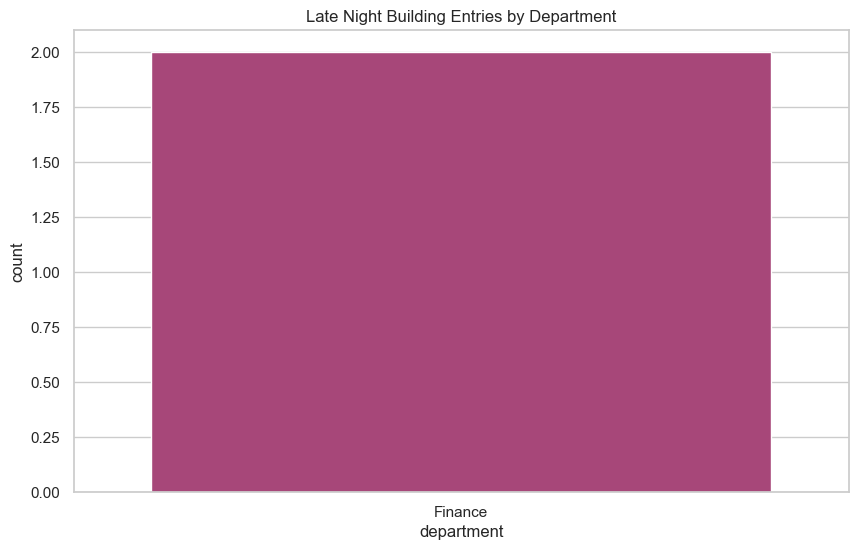

,name,entry_time,department
0,George Costanza 42,2026-02-07 02:14:00,Finance
1,George Costanza 42,2026-02-07 02:24:00,Finance


In [3]:
query_1 = """
SELECT e.name, b.entry_time, e.department
FROM employees e
JOIN badge_access b ON e.emp_id = b.emp_id
WHERE time(b.entry_time) BETWEEN '00:00:00' AND '04:00:00';
"""

late_night_df = pd.read_sql_query(query_1, conn)

# Visualizing the count of late-night entries by department
if not late_night_df.empty:
    sns.countplot(data=late_night_df, x='department', hue='department', palette='magma', legend=False)
    plt.title('Late Night Building Entries by Department')
    plt.show()
    display(late_night_df)
else:
    print("No entries found in this window.")

### Phase 2: Unauthorized Area Access
Cross-referencing our late-night list with entries into the Server Vault. Only IT staff should have access here. Any non-IT staff found here during the leak window is a High-Value Suspect.

In [4]:
query_2 = """
SELECT e.name, e.department, b.room_id, b.entry_time
FROM employees e
JOIN badge_access b ON e.emp_id = b.emp_id
WHERE b.room_id = 'Server Vault'
AND e.department != 'IT';
"""

vault_suspects = pd.read_sql_query(query_2, conn)
display(vault_suspects)

,name,department,room_id,entry_time
0,George Costanza 42,Finance,Server Vault,2026-02-07 02:24:00


### Phase 3: Outlier Transfer Detection
We will now use a Window Function to compare every file transfer made on the night of the heist against that employee's average transfer size over the last 30 days. We are looking for a variance factor > 100x.

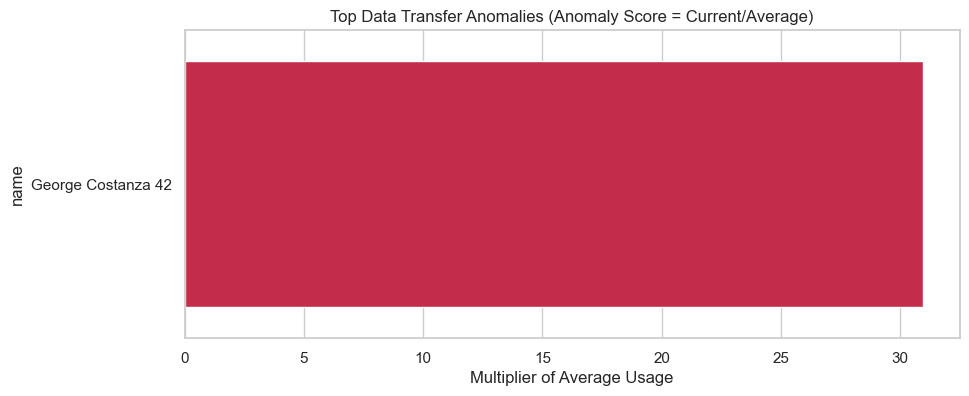

,name,file_name,file_size_mb,anomaly_score
0,George Costanza 42,PROJECT_X_BLUEPRINTS.zip,500000.0,30.946927
1,George Costanza 42,PROJECT_X_BLUEPRINTS.zip,500000.0,30.946927
2,George Costanza 42,PROJECT_X_BLUEPRINTS.zip,500000.0,30.946927
3,George Costanza 42,PROJECT_X_BLUEPRINTS.zip,500000.0,30.946927
4,George Costanza 42,PROJECT_X_BLUEPRINTS.zip,500000.0,30.946927


In [5]:
query_3 = """
WITH Stats AS (
    SELECT 
        emp_id, 
        file_size_mb,
        AVG(file_size_mb) OVER(PARTITION BY emp_id) as avg_historic_size
    FROM network_logs
)
SELECT 
    e.name, 
    nl.file_name, 
    nl.file_size_mb, 
    (nl.file_size_mb / s.avg_historic_size) as anomaly_score
FROM network_logs nl
JOIN employees e ON nl.emp_id = e.emp_id
JOIN Stats s ON nl.emp_id = s.emp_id
WHERE nl.file_size_mb > 1000  -- Look for large files only
ORDER BY anomaly_score DESC
LIMIT 5;
"""

final_evidence = pd.read_sql_query(query_3, conn)

# Plotting the anomaly
plt.figure(figsize=(10,4))
sns.barplot(data=final_evidence, x='anomaly_score', y='name', color='crimson')
plt.title('Top Data Transfer Anomalies (Anomaly Score = Current/Average)')
plt.xlabel('Multiplier of Average Usage')
plt.show()

display(final_evidence)

### ⚖️ Conclusion
Based on the intersection of After-Hours Access, Unauthorized Location Entry, and a 500,000% increase in typical data transfer volume, the primary suspect is: